# Gene Signatures - How to score & interpret
**author**: "Marc Elosua Bayes" \
**date**: "09/01/2023"

## Introduction

Gene signatures are commonly used in routine single cell analysis. Many methods exists but they are not all created equally. In this tutorial we are going to go follow a recent benchmarking paper @badia-i-mompel2022 and follow their guidelines on best practices when scoring gene signatures!

With this tutorial we hope to familiarize you with the concepts of gene signatures, how they are scored in single cell datasets and how to interpret the scores obtained!

Before we start here are some key concepts that will help us and frame the vignette!

-   **What is a gene signature?**

    A *"gene signature"* can be stated as a single or a group of genes in a cell having a unique pattern of gene expression that is the consequence of either changed biological process or altered pathogenic medical terms @mallik2018.

-   **What is a cell type signature?**

    A cell type signature is a gene signature representing a group of genes underlying the biological processes characteristic of a cell type.

-   **How do we score them in our dataset?**

    Scoring a gene signature means to obtain a value for that signature for each cell in our datasets that represents how active the gene program is in each cell. There are many ways to score gene signatures as shown in the `decoupleR` paper @badia-i-mompel2022. However, they do not all perform the same and it is important to select a robust method. The suggested method after their benchmarking analysis is running a Univariate Linear Model (ULM) where the gene expression values are the response variable and the regulator weights in the gene signature are the explanatory one (don't worry, we'll go through this in more detail in a second). The obtained t-value from the fitted model is the activity score of that gene signature in that cell.

-   **How do we interpret that score?**

    Scoring gene signatures using Univariate Linear Models and using the resulting t-value as the scoring metric allows us to simultaneously interpret in a single statistic the direction of activity (either + or -) and its significance (the magnitude of the score).

-   **Can we interrogate the scores obtained?**

    Yes! In fact it is very important to look past the score obtained by a cell and into which are the genes driving that score. Sometime with gene signatures containing 50 genes it could be that just a few genes are contributing to the signature. If we just stopped at the score we could be mislead into thinking that all of the genes making up the signature are important when it is actually only a fraction of them. Moreover, heterogeneous gene expression between two populations can also lead to 2 cells or populations having similar scores but vastly different genes gene programs underlying them.



## Loading packages

In [24]:
import decoupler as dc

# Only needed for visualization:
from plotnine import *
import scanpy as sc
import random
import pandas as pd


Some settings to use throughout the document

In [8]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=300, facecolor='white', frameon=False)
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

# Set seed for reproducibility
random.seed(10)

scanpy==1.9.4 anndata==0.9.2 umap==0.5.3 numpy==1.24.3 scipy==1.11.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 pynndescent==0.5.10


## Load Data

In [5]:
adata = sc.datasets.pbmc3k_processed()

try downloading from url
https://raw.githubusercontent.com/chanzuckerberg/cellxgene/main/example-dataset/pbmc3k.h5ad
... this may take a while but only happens once


100%|██████████| 23.5M/23.5M [00:00<00:00, 36.9MB/s]


We can visualize the different cell types in it:

/Users/marc/anaconda3/envs/gs/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


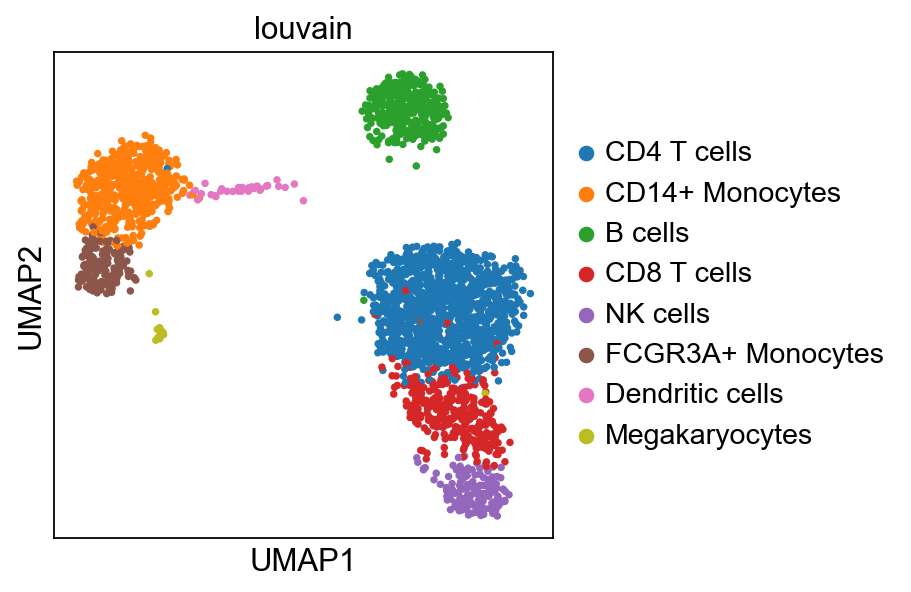

In [6]:
sc.pl.umap(adata, color='louvain')

### Gene Signature Scoring
Here we define some gene signatures based on prior knowledge. We are setting gene signature that are characteristic for specific cell types to score for their activities in our dataset.


In [14]:
bcell = ["MS4A1", "CD79A", "CD79B", "BANK1", "HLA-DQB1", "HLA-DQA1"]
tcell = ["CD3D", "CD3E", "TRAC", "TRBC1", "TRBC2", "CD4", "CD8A", "CD8B"]
tnaive = tcell + ["IL7R", "CCR7", "TCF7", "LEF1", "SELL"]
cd8cyto = tcell + ["GZMA", "GZMK", "NKG7", "CCL5"]
mono = ["FCGR3A", "CD14", "S100A9", "S100A8", "MS4A7"]
nks = ["NCR1", "NCR2", "NCR3", "FCGR3A", "GZMA", "GZMK", "NKG7", "CCL5"]

,signature,gene,mor
0,B cells,MS4A1,1
1,B cells,CD79A,1
2,B cells,CD79B,1
3,B cells,BANK1,1
4,B cells,HLA-DQB1,1
5,B cells,HLA-DQA1,1
6,T cells,CD3D,1
7,T cells,CD3E,1
8,T cells,TRAC,1
9,T cells,TRBC1,1


We can see how there are some genes that are specific for each signature but others are shared between them. This is important to take into account when computing the gene signatures and interpreting their scores.

To help us compute these gene signatures we are going to use the R package [`decoupleR`](https://www.bioconductor.org/packages/release/bioc/html/decoupleR.html) from Bioconductor. `decoupleR` is a great for carrying out these analysis since it is a framework that contains different statistical methods to compute these scores. Ultimately we will obtain a score for each signature for each cell.

`decoupleR` requires the gene signatures to be passed as a dataframe so we are going to convert our gene signature vectors into a unified dataframe. `mor` stands for *Mode Of Regulation*, at the moment since we don't have a score of how important that gene is for that signature we are going to weight them all equally with a value of 1.

In [ ]:
sig_dict = {
    "B cells": bcell,
    "T cells": tcell,
    "Naive T cells": tnaive,
    "CD8 Cytotoxic": cd8cyto,
    "Monocytes": mono,
    "NKs": nks
}
sig_dict
sig_df = pd.concat([pd.DataFrame({'signature': key, 'gene': value, 'mor': 1}) for key, value in sig_dict.items()], ignore_index=True)
sig_df

### ULM
*"Univariate Linear Model (ULM) fits a linear model for each sample and regulator, where the observed molecular readouts in mat are the response variable and the regulator weights in net are the explanatory one. Target features with no associated weight are set to zero. The obtained t-value from the fitted model is the activity ulm of a given regulator."*

![](img/ulm.png){width="584"}

Moreover, a nice thing about `ulm` is that in a single statistic it provides the direction of activity (either + or -) and its significance (the magnitude of the score). Making the scores very easy to interpret!

So lets compute the signature scores for every cell in our dataset!

In [16]:
dc.run_ulm(
    mat=adata,
    net=sig_df,
    source='signature',
    target='gene',
    weight='mor',
    verbose=True
)

1 features of mat are empty, they will be removed.
Running ulm on mat with 2638 samples and 13713 targets for 6 sources.


100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


The obtained scores (ulm_estimate) and p-values (ulm_pvals) are stored in the .obsm key. We can see how every cells has a score for every signature!

In [53]:
adata.obsm['ulm_estimate']

# Looking at all the scores for one specific cell
adata.obsm['ulm_estimate'].loc['AAACATACAACCAC-1']


# Check if the results are concordant between Python and R 
print(adata.obsm['ulm_estimate'].loc['TTTGCATGAGAGGC-1'])
print(adata.obsm['ulm_estimate'].loc['AAGATGGAGATAAG-1'])


B cells          10.568047
CD8 Cytotoxic    -0.487455
Monocytes        -0.363227
NKs              -0.429761
Naive T cells    -0.513746
T cells          -0.363279
Name: TTTGCATGAGAGGC-1, dtype: float32
B cells          0.617235
CD8 Cytotoxic   -0.126399
Monocytes        7.572541
NKs              0.049956
Naive T cells    0.406961
T cells         -0.571647
Name: AAGATGGAGATAAG-1, dtype: float32


We can see how the results maintain the same direction but are slightly different in their magnitude. This can be driven by multiple factors, 1) the normalization is slightly different between Scanpy and Seurat see more details [here](https://twitter.com/lpachter/status/1694387749967847874). Moreover, there are slightly different implementations to compute linear models between R and Python. While R keeps all the features (genes) Python discards those that are all 0s thus decreasing the degrees of freedom.

#### How does a univariate linear model work?
Lets start with a toy example. Imagine a very simple scenario where we have two very simple vectors where one is double the other. We can compute the linear model and also easily visualize the relationship between both vectors:

In [38]:
from scipy.stats import linregress  # Import linregress from scipy.stats
# Define data as a DataFrame
df = pd.DataFrame({'vec1': [1, 2, 5], 'vec2': [2.1, 3.8, 9.7]})
# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(df['vec1'], df['vec2'])

y = 1.92x + 0.09


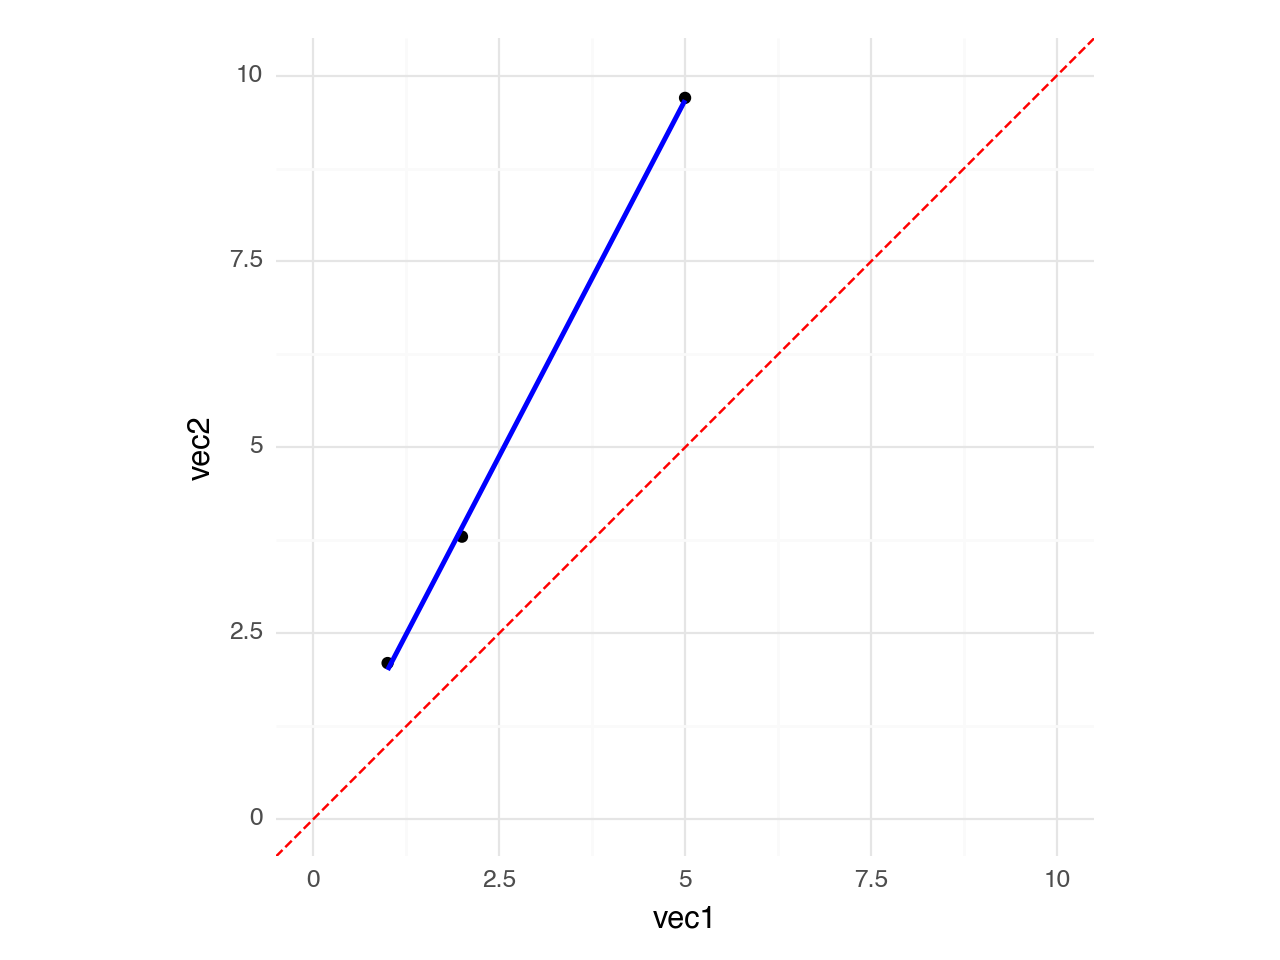

In [51]:
form = f'y = {slope:.2f}x + {intercept:.2f}'
print(form)
# Create the scatter plot with regression line and equation
p = (
    ggplot(df, aes(x='vec1', y='vec2')) +
    geom_point() +
    geom_abline(intercept=0, slope=1, color="red", linetype="dashed") +
    geom_smooth(method='lm', se=False, color='blue', formula='y ~ x') +
    coord_fixed() +
    xlim(0, 10) +
    ylim(0, 10) +
    theme_minimal()
)

print(p)

In the example above we see the linear relationship between both vectors and we get the slope and the T value:\
- The **slope** indicates the what is the change in the response variable (vec2) given a 1 unit change in the predictor variable (vec1).

\- The **T statistic** is the result of a T test. The T test assesses the significance of individual coefficients in our model. The T value indicates the number of standard errors the estimated coefficient is away from the null hypothesis (t = 0). Remember the T value is the $\frac{coefficient}{standard~error}$.

For a real world example please visit the Quarto R document [here](https://htmlpreview.github.io/?https://github.com/CellDiscoveryNetwork/teaching-resources/blob/main/gene-signatures-1/gene-signatures.html) where all the calculations are carried out!

#### Visualization
To visualize the obtained scores, we can re-use many of scanpy’s plotting functions. First though, we need to extract them from the adata object.

In [54]:
acts = dc.get_acts(adata, obsm_key='ulm_estimate')
acts

AnnData object with n_obs × n_vars = 2638 × 6
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'ulm_estimate', 'ulm_pvals'

dc.get_acts returns a new AnnData object which holds the obtained activities in its .X attribute, allowing us to re-use many scanpy functions, for example:

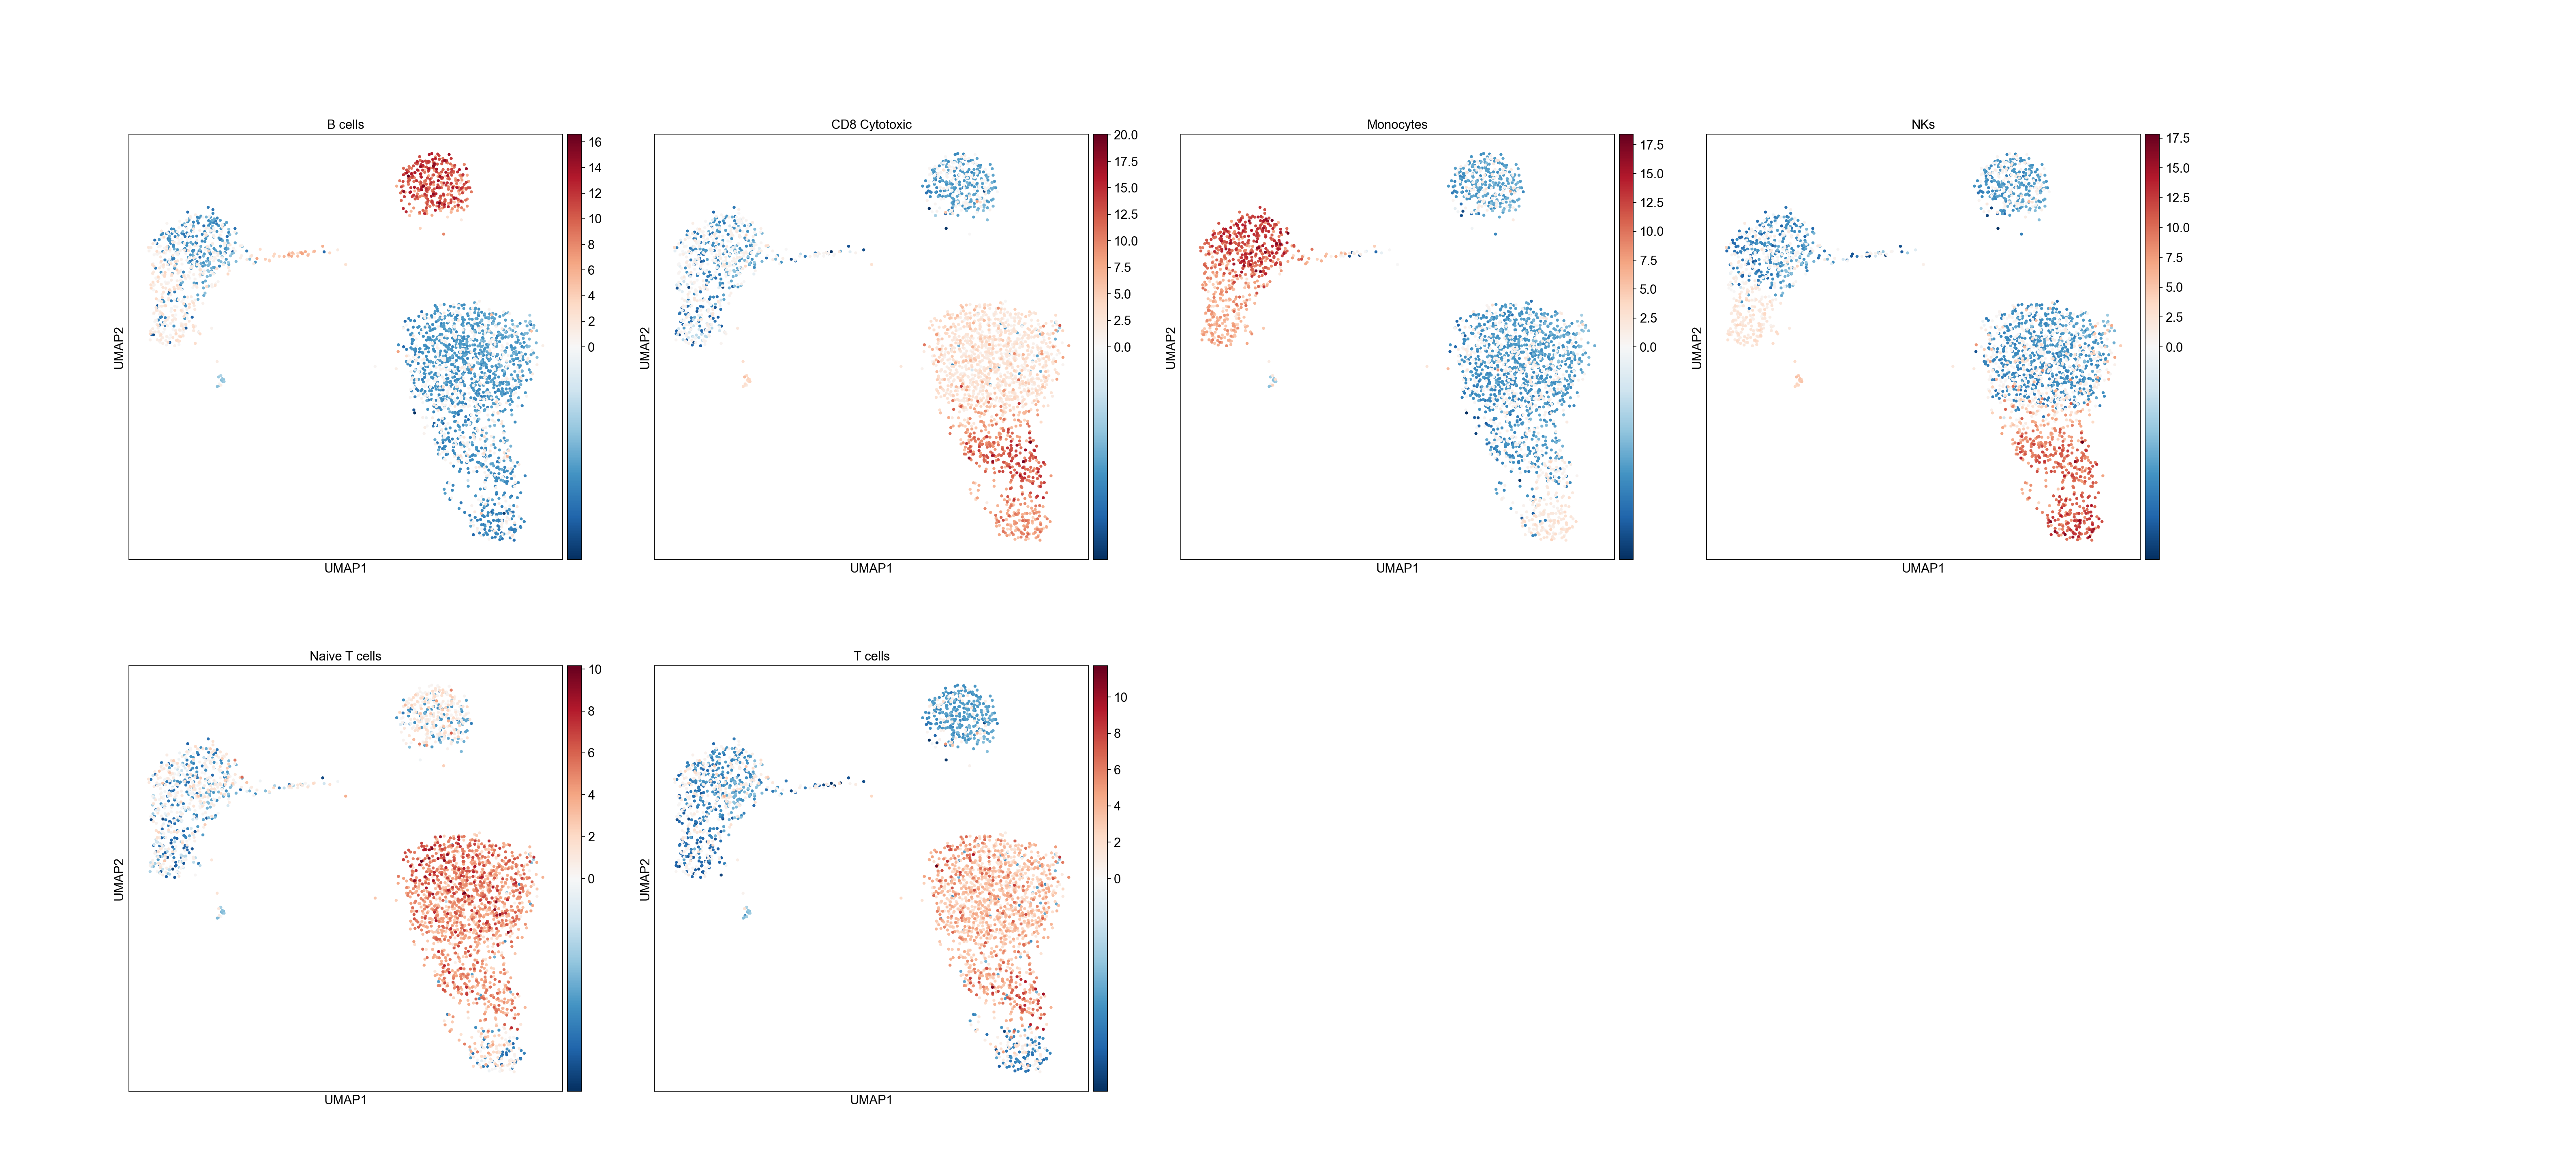

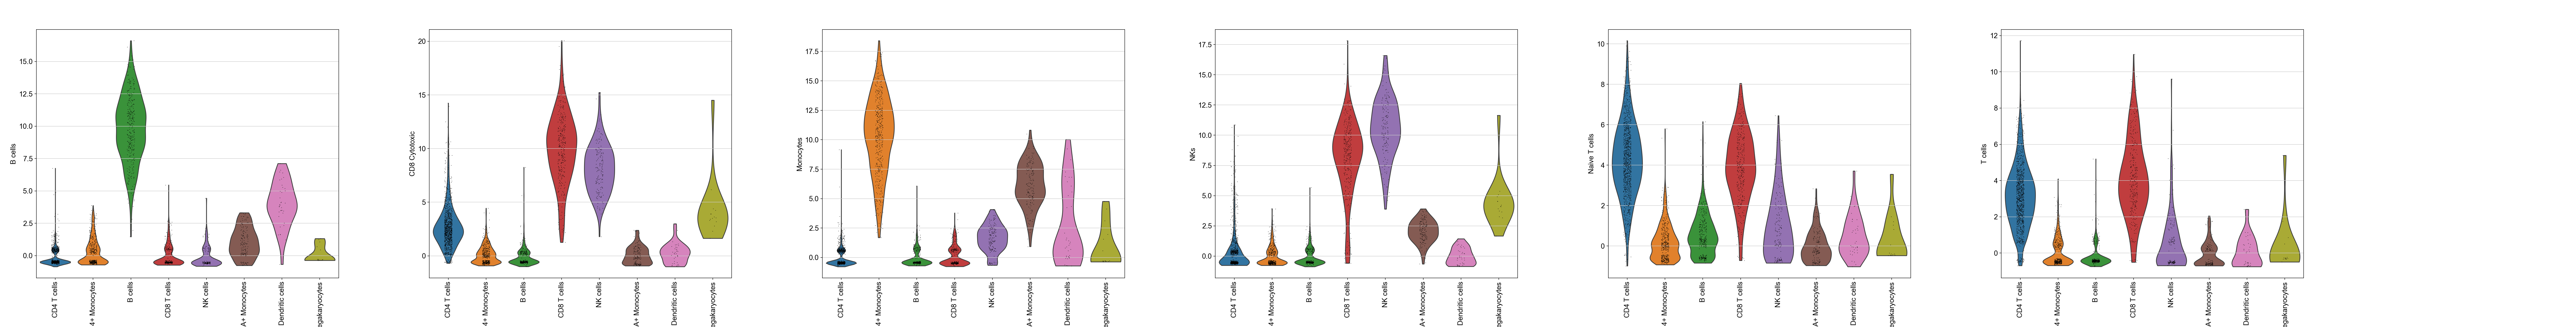

In [86]:
sc.pl.umap(acts, color=acts.var_names, cmap='RdBu_r', vcenter=0)
sc.pl.violin(acts, keys=acts.var_names, groupby='louvain', rotation=90)

##### Heatmap by groups
We can also visualize the gene signature scores for each cell type using a heatmap


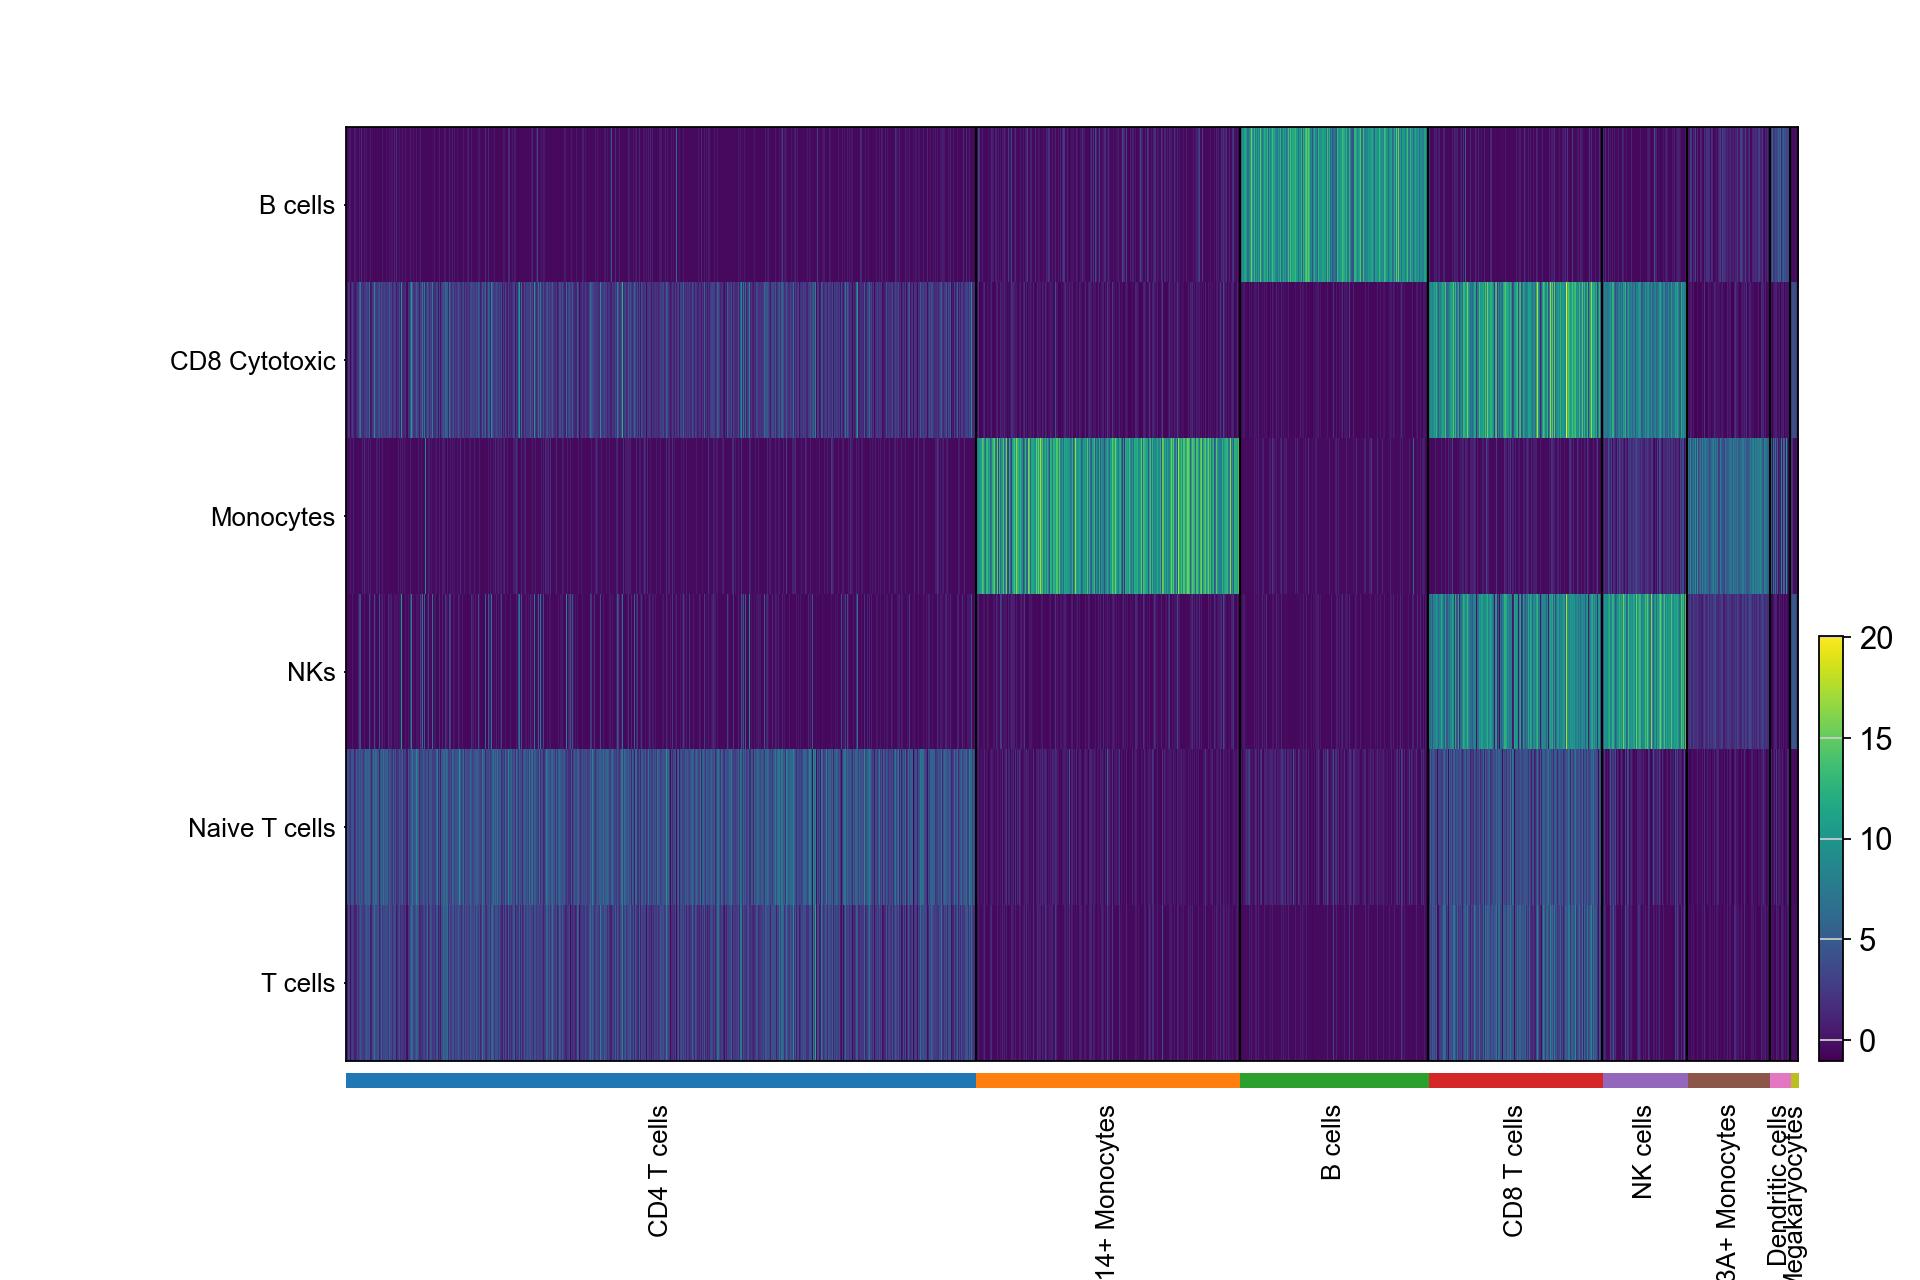

In [81]:
sc.pl.heatmap(acts, acts.var_names, groupby='louvain', swap_axes=True, figsize=(12, 8))


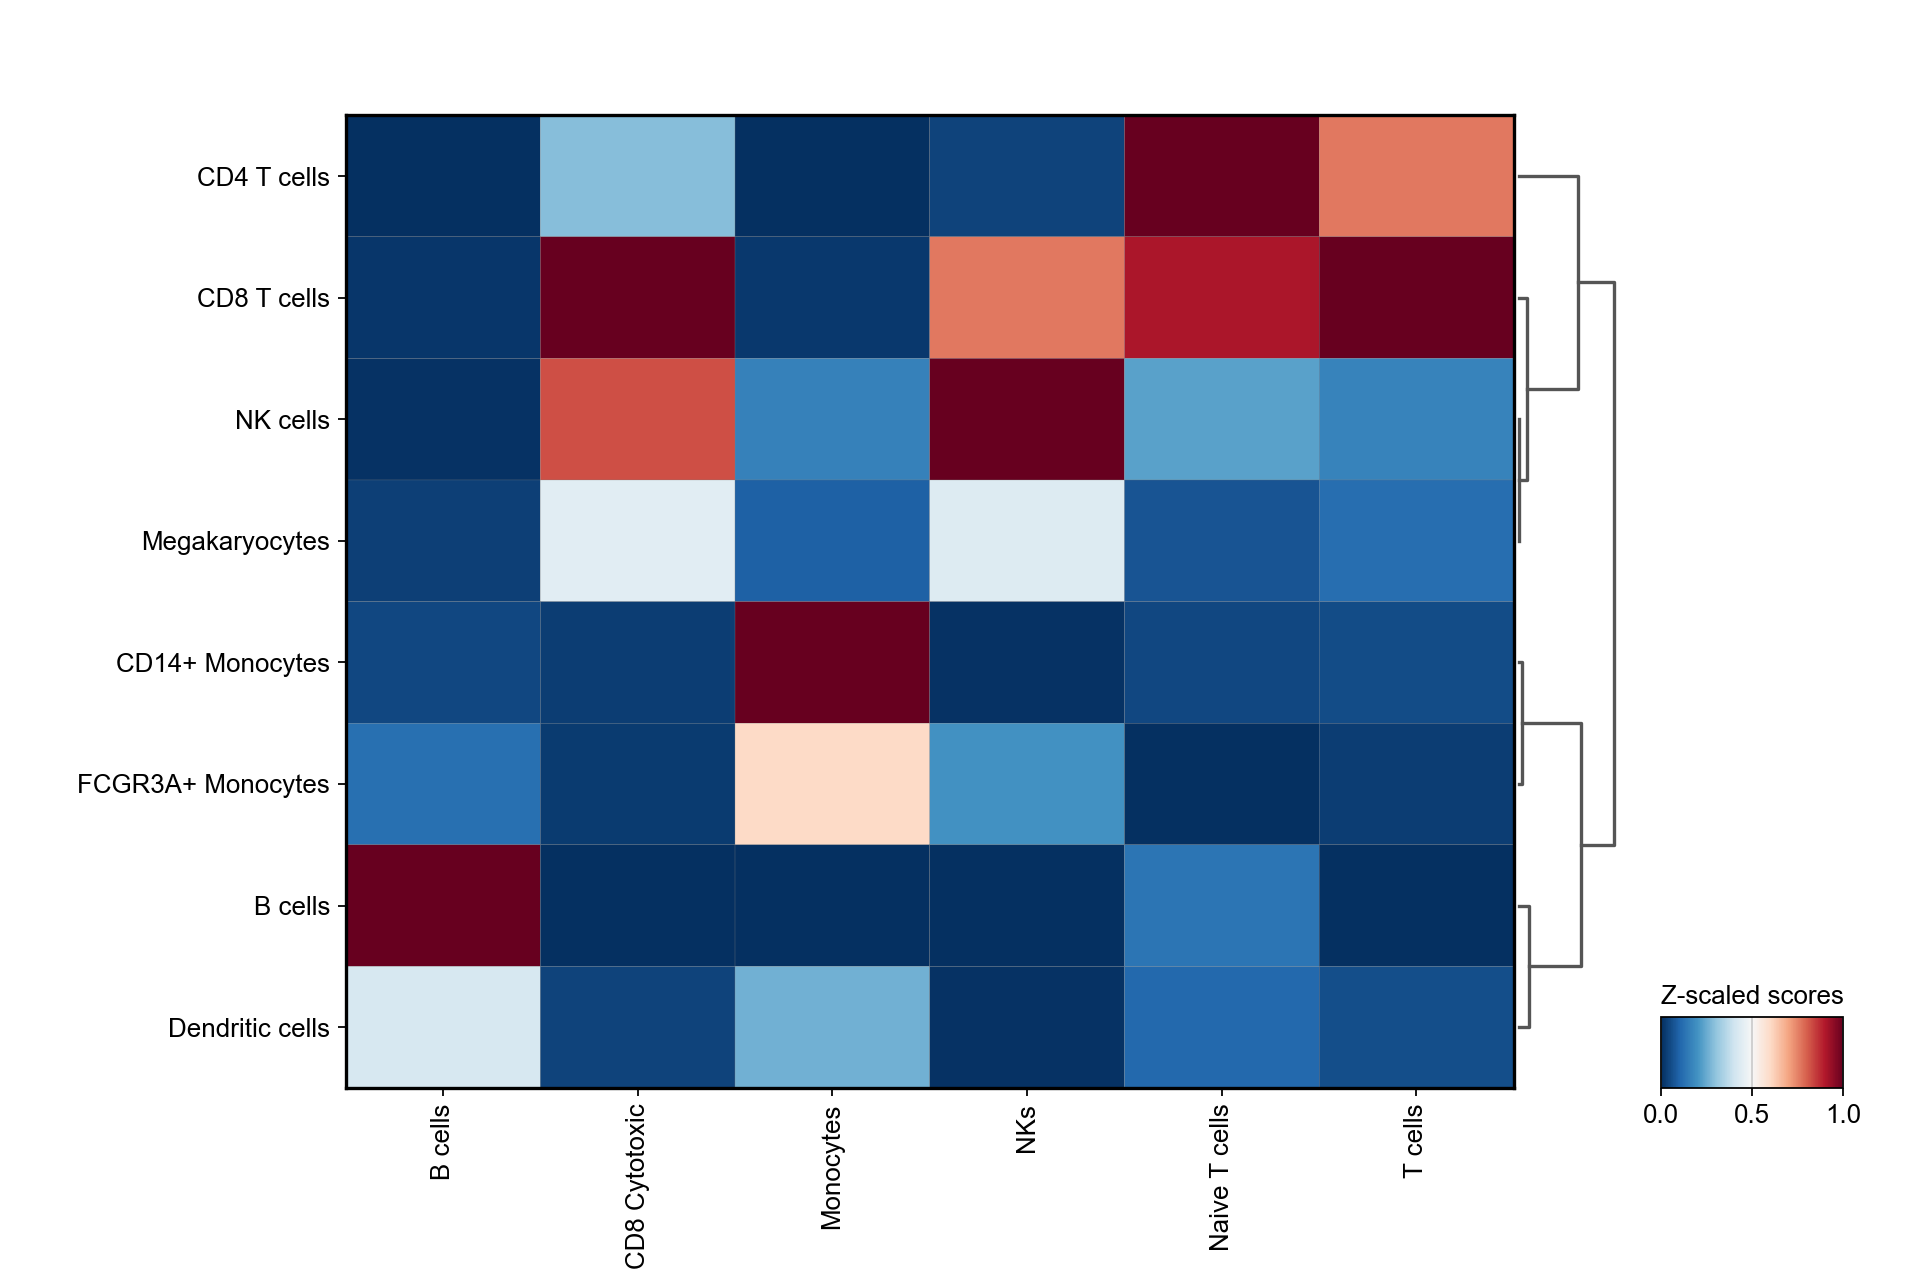

In [82]:
sc.pl.matrixplot(acts, acts.var_names, 'louvain', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', figsize=(12, 8))

In [88]:
import session_info
session_info.show(html=False, dependencies=True)

Python version: 3.10.12 (main, Jul  5 2023, 15:02:25) [Clang 14.0.6 ]
Operating System: macOS-13.4-arm64-arm-64bit
System Architecture: ('64bit', '')
Python Info: sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)
Package Versions:
Babel: 2.12.1
Bottleneck: 1.3.5
Jinja2: 3.1.2
MarkupSafe: 2.1.3
Pillow: 10.0.0
PyYAML: 6.0.1
Pygments: 2.16.1
Send2Trash: 1.8.2
anndata: 0.9.2
anyio: 4.0.0
appnope: 0.1.3
argon2-cffi: 23.1.0
argon2-cffi-bindings: 21.2.0
arrow: 1.2.3
asttokens: 2.2.1
async-lru: 2.0.4
attrs: 23.1.0
backcall: 0.2.0
beautifulsoup4: 4.12.2
bleach: 6.0.0
certifi: 2023.7.22
cffi: 1.15.1
charset-normalizer: 3.2.0
colorama: 0.4.6
comm: 0.1.4
contourpy: 1.0.5
cycler: 0.11.0
debugpy: 1.6.7.post1
decorator: 5.1.1
decoupler: 1.5.0
defusedxml: 0.7.1
exceptiongroup: 1.1.3
executing: 1.2.0
fastjsonschema: 2.18.0
fonttools: 4.25.0
fqdn: 1.5.1
h5py: 3.9.0
idna: 3.4
importlib-metadata: 6.8.0
ipykernel: 6.25.1
ipython: 8.15.0
isoduration: 20.11.0
jedi: 0.19.0
joblib: 